In [41]:
!pip install ultralytics > /dev/null 2>&1
import cv2
from ultralytics import YOLO

# Result By Different Training by setting Parameter Combination:

### By changing Weights which we get by training we have different models and we can apply those on all test videos

## Ball Tracker

In [42]:
from ultralytics import YOLO
import cv2
import os
import pickle
import pandas as pd

class BallTracker:
    def __init__(self, model_path):
        self.model = YOLO(model_path)

    def interpolate_ball_positions(self, ball_positions):
        ball_positions = [x.get(1, []) for x in ball_positions]
        df_ball_positions = pd.DataFrame(ball_positions, columns=['x1', 'y1', 'x2', 'y2']).interpolate().bfill()
        return [{1: x} for x in df_ball_positions.to_numpy().tolist()]

    def get_ball_shot_frames(self, ball_positions):
        ball_positions = [x.get(1, []) for x in ball_positions]
        df_ball_positions = pd.DataFrame(ball_positions, columns=['x1', 'y1', 'x2', 'y2'])
        df_ball_positions['ball_hit'] = 0
        df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2']) / 2
        df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1).mean()
        df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()
        
        for i in range(1, len(df_ball_positions) - 30):  # Adjust frame gap as necessary
            if df_ball_positions['delta_y'].iloc[i] * df_ball_positions['delta_y'].iloc[i + 1] < 0:
                df_ball_positions.loc[i, 'ball_hit'] = 1

        return df_ball_positions[df_ball_positions['ball_hit'] == 1].index.tolist()

    def detect_frames(self, frames):
        ball_detections = []
        for frame in frames:
            results = self.model.predict(frame, conf=0.05,verbose=False)[0]
            ball_dict = {}
            for box in results.boxes:
                result = box.xyxy.tolist()[0]
                ball_dict[1] = result
            ball_detections.append(ball_dict)
        return ball_detections

    def draw_bboxes(self, video_frames, player_detections):
        output_video_frames = []
        for frame, ball_dict in zip(video_frames, player_detections):
            for track_id, bbox in ball_dict.items():
                x1, y1, x2, y2 = bbox
                cv2.putText(frame, f"Ball ID: {track_id}", (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)  # Red color
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)  # Red bounding box
            output_video_frames.append(frame)
        return output_video_frames

    def process_videos(self, video_paths, output_dir):
        ball_detection_counts = {}
        os.makedirs(output_dir, exist_ok=True)

        for video_path in video_paths:
            cap = cv2.VideoCapture(video_path)
            frames = []
            ball_count = 0
            video_name = os.path.basename(video_path)

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                frames.append(frame)
            cap.release()

            # Detect tennis balls in frames and interpolate positions
            ball_detections = self.detect_frames(frames)
            interpolated_positions = self.interpolate_ball_positions(ball_detections)
            ball_hits = self.get_ball_shot_frames(interpolated_positions)
            ball_count += len(ball_hits)
            ball_detection_counts[video_name] = ball_count

            # Draw bounding boxes and save the video
            output_frames = self.draw_bboxes(frames, ball_detections)
            output_video_path = os.path.join(output_dir, f"{video_name}_output.mp4")
            out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (output_frames[0].shape[1], output_frames[0].shape[0]))
            for frame in output_frames:
                out.write(frame)
            out.release()

        return ball_detection_counts




# Changing confidence we get different results 



In [64]:
def count_and_track_ball_detections(video_paths, conf=0.05):
    ball_detection_counts = {}

    # Iterate over each video path
    for video_path in video_paths:
        cap = cv2.VideoCapture(video_path)
        ball_count = 0  # Counter for sports ball detections
        frames_with_detections = 0  # Counter for frames containing at least one tennis ball
        total_frames = 0  # Counter for total frames processed
        video_name = video_path.split('/')[-1]  # Extract video file name

        # Process the video frame by frame
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Increment total frame count
            total_frames += 1

            # Detect objects in the frame using YOLO
            results = model(frame, conf=conf, verbose=False)

            # Flag to check if this frame has at least one detection
            frame_has_detection = False

            # Iterate over detected objects and count tennis balls
            for result in results:
                for obj in result.boxes:
                    # Check if the label is 'tennis ball'
                    if 'tennis ball' in result.names[int(obj.cls)]:
                        ball_count += 1
                        frame_has_detection = True  # Set flag if a tennis ball is detected in this frame

            # If this frame had any detections, increment the frames_with_detections counter
            if frame_has_detection:
                frames_with_detections += 1

        # Store the counts for this video
        ball_detection_counts[video_name] = {
            "total_detections": ball_count,
            "frames_with_detections": frames_with_detections,
            "total_frames": total_frames
        }

        # Release the video capture for this file
        cap.release()
    
    return ball_detection_counts




In [65]:
# Initialize tracker with model path and output directory
# tracker = BallTracker(model_path='/kaggle/input/updated-train-result-best2/best (2).pt')
model = YOLO('/kaggle/input/updated-train-result-best2/best (2).pt')
class_names = model.names
print(class_names)
# List of video paths with various speeds
video_paths_list = [
    '/kaggle/input/different-speed-of-tennis-data-set/0.25_x_input_video.mp4',
    '/kaggle/input/different-speed-of-tennis-data-set/0.50_x_input_video.mp4',
    '/kaggle/input/different-speed-of-tennis-data-set/1_x_input_video.mp4',
    '/kaggle/input/different-speed-of-tennis-data-set/1.5_x_input_video.mp4',
    '/kaggle/input/different-speed-of-tennis-data-set/2_x_input_video.mp4',
    '/kaggle/input/different-speed-of-tennis-data-set/4_x_input_video.mp4'
]

# Run the ball counting and tracking process
ball_counts = count_and_track_ball_detections(video_paths_list, conf=0.05)

# Output ball detection results
print(ball_counts)


{0: 'tennis ball'}
{'0.25_x_input_video.mp4': {'total_detections': 542, 'frames_with_detections': 498, 'total_frames': 855}, '0.50_x_input_video.mp4': {'total_detections': 267, 'frames_with_detections': 246, 'total_frames': 427}, '1_x_input_video.mp4': {'total_detections': 137, 'frames_with_detections': 126, 'total_frames': 214}, '1.5_x_input_video.mp4': {'total_detections': 88, 'frames_with_detections': 80, 'total_frames': 144}, '2_x_input_video.mp4': {'total_detections': 73, 'frames_with_detections': 68, 'total_frames': 109}, '4_x_input_video.mp4': {'total_detections': 34, 'frames_with_detections': 31, 'total_frames': 55}}


In [66]:
# video_paths = [
#     '/kaggle/input/different-speed-of-tennis-data-set/0.25_x_input_video.mp4',  # 0.25x speed video
#     '/kaggle/input/different-speed-of-tennis-data-set/0.50_x_input_video.mp4',     # 0.5x speed video
#     '/kaggle/input/different-speed-of-tennis-data-set/1_x_input_video.mp4', #1x speed Video
#     '/kaggle/input/different-speed-of-tennis-data-set/1.5_x_input_video.mp4', #1.5x Speed Video
#     '/kaggle/input/different-speed-of-tennis-data-set/2_x_input_video.mp4',      # 2x speed video
#     '/kaggle/input/different-speed-of-tennis-data-set/4_x_input_video.mp4'    # 4x speed Video
# ]    
# for video in video_paths:
#     model = model=YOLO('/kaggle/input/updated-train-result-best2/best (2).pt')

#     result = model.track(video,conf=0.05, save=True,verbose=False)

In [67]:
ball_counts

{'0.25_x_input_video.mp4': {'total_detections': 542,
  'frames_with_detections': 498,
  'total_frames': 855},
 '0.50_x_input_video.mp4': {'total_detections': 267,
  'frames_with_detections': 246,
  'total_frames': 427},
 '1_x_input_video.mp4': {'total_detections': 137,
  'frames_with_detections': 126,
  'total_frames': 214},
 '1.5_x_input_video.mp4': {'total_detections': 88,
  'frames_with_detections': 80,
  'total_frames': 144},
 '2_x_input_video.mp4': {'total_detections': 73,
  'frames_with_detections': 68,
  'total_frames': 109},
 '4_x_input_video.mp4': {'total_detections': 34,
  'frames_with_detections': 31,
  'total_frames': 55}}

In [68]:
for key, values in ball_counts.items():
    total_detections = values['total_detections']
    total_frames = values['total_frames']
    detection_ratio = total_detections / total_frames  # Calculate ratio
    values['detection_ratio'] = round(detection_ratio,2)  # Add new key-value pair

# Output the modified dictionary
ball_counts

{'0.25_x_input_video.mp4': {'total_detections': 542,
  'frames_with_detections': 498,
  'total_frames': 855,
  'detection_ratio': 0.63},
 '0.50_x_input_video.mp4': {'total_detections': 267,
  'frames_with_detections': 246,
  'total_frames': 427,
  'detection_ratio': 0.63},
 '1_x_input_video.mp4': {'total_detections': 137,
  'frames_with_detections': 126,
  'total_frames': 214,
  'detection_ratio': 0.64},
 '1.5_x_input_video.mp4': {'total_detections': 88,
  'frames_with_detections': 80,
  'total_frames': 144,
  'detection_ratio': 0.61},
 '2_x_input_video.mp4': {'total_detections': 73,
  'frames_with_detections': 68,
  'total_frames': 109,
  'detection_ratio': 0.67},
 '4_x_input_video.mp4': {'total_detections': 34,
  'frames_with_detections': 31,
  'total_frames': 55,
  'detection_ratio': 0.62}}

In [69]:
# Convert dictionary to DataFrame
df = pd.DataFrame.from_dict(ball_counts, orient="index").reset_index()

# Rename the index column to 'video format'
df = df.rename(columns={'index': 'video format'})

# Display DataFrame
(df)


,video format,total_detections,frames_with_detections,total_frames,detection_ratio
0,0.25_x_input_video.mp4,542,498,855,0.63
1,0.50_x_input_video.mp4,267,246,427,0.63
2,1_x_input_video.mp4,137,126,214,0.64
3,1.5_x_input_video.mp4,88,80,144,0.61
4,2_x_input_video.mp4,73,68,109,0.67
5,4_x_input_video.mp4,34,31,55,0.62


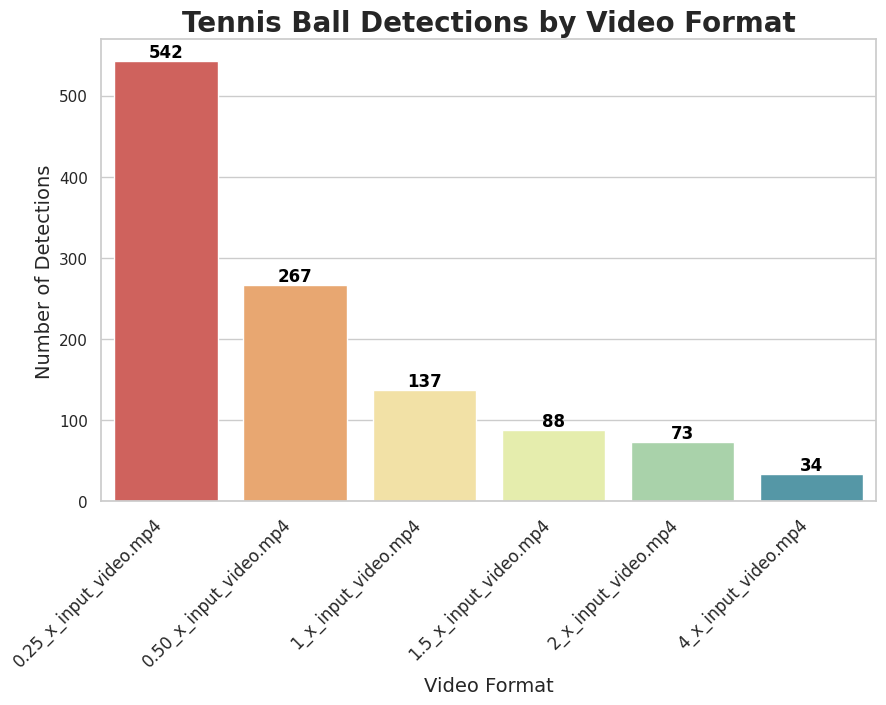

In [70]:

import seaborn as sns
import matplotlib.pyplot as plt

# Set the style and figure size
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Define color palette and create the bar plot
colors = sns.color_palette("Spectral", len(df))  # Use a vibrant color palette
ax = sns.barplot(x='video format', y='total_detections', data=df, palette=colors)  # Added missing parenthesis

# Add plot titles and axis labels
plt.title('Tennis Ball Detections by Video Format', fontsize=20, fontweight='bold')
plt.xlabel('Video Format', fontsize=14)
plt.ylabel('Number of Detections', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add value labels on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Show plot with


In [71]:
from prettytable import PrettyTable



# Create a PrettyTable object
table = PrettyTable()

# Add columns to the table
table.field_names = ["Video Name", "Total Detections", "Total Frames", "Detection Ratio"]

# Add rows to the table
for video_name, metrics in ball_counts.items():
    table.add_row([video_name, metrics['total_detections'], metrics['total_frames'], metrics['detection_ratio']])

# Print the table
print(table)


+------------------------+------------------+--------------+-----------------+
|       Video Name       | Total Detections | Total Frames | Detection Ratio |
+------------------------+------------------+--------------+-----------------+
| 0.25_x_input_video.mp4 |       542        |     855      |       0.63      |
| 0.50_x_input_video.mp4 |       267        |     427      |       0.63      |
|  1_x_input_video.mp4   |       137        |     214      |       0.64      |
| 1.5_x_input_video.mp4  |        88        |     144      |       0.61      |
|  2_x_input_video.mp4   |        73        |     109      |       0.67      |
|  4_x_input_video.mp4   |        34        |      55      |       0.62      |
+------------------------+------------------+--------------+-----------------+


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


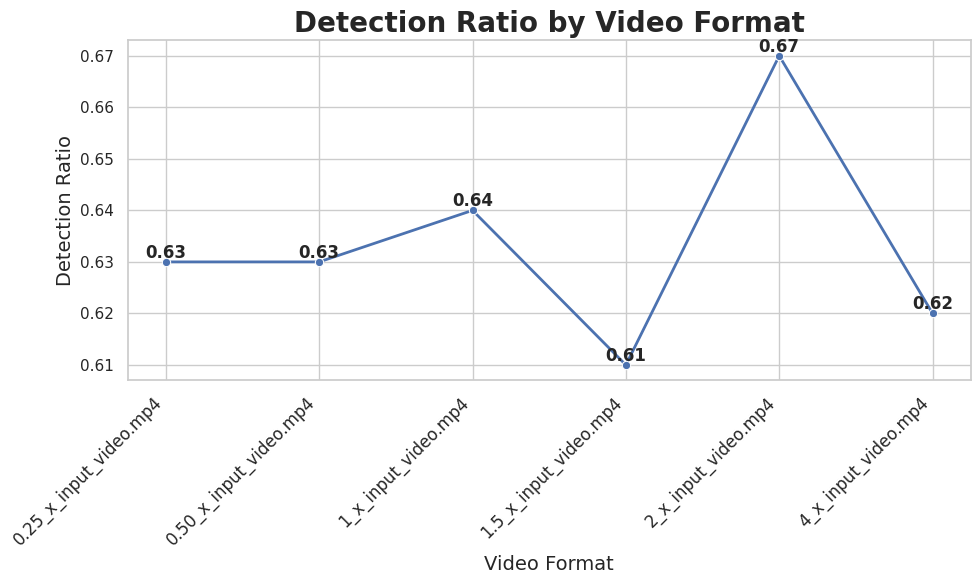

In [72]:
# Plot the line graph 
# Set the style and figure size
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Plot the line graph for detection ratio
ax = sns.lineplot(x='video format', y='detection_ratio', data=df, marker='o', color='b', linewidth=2)

# Add plot titles and axis labels
plt.title('Detection Ratio by Video Format', fontsize=20, fontweight='bold')
plt.xlabel('Video Format', fontsize=14)
plt.ylabel('Detection Ratio', fontsize=14)

# Add value labels for each point
for x, y in zip(df['video format'], df['detection_ratio']):
    ax.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Show plot with tighter layout
plt.tight_layout()
plt.show()


# Novel Approach TO Capture the Ball  and HIT COUNT


In [73]:
import cv2
import os
import pickle
import pandas as pd
from ultralytics import YOLO

class BallTracker:
    def __init__(self, model_path):
        self.model = YOLO(model_path)

    def interpolate_ball_positions(self, ball_positions):
        ball_positions = [x.get(1, []) for x in ball_positions]
        df_ball_positions = pd.DataFrame(ball_positions, columns=['x1', 'y1', 'x2', 'y2'])
        df_ball_positions = df_ball_positions.interpolate().bfill()
        ball_positions = [{1: x} for x in df_ball_positions.to_numpy().tolist()]
        return ball_positions

    def get_ball_shot_frames(self, ball_positions):
        ball_positions = [x.get(1, []) for x in ball_positions]
        df_ball_positions = pd.DataFrame(ball_positions, columns=['x1', 'y1', 'x2', 'y2'])
        df_ball_positions['ball_hit'] = 0
        df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2']) / 2
        df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1).mean()
        df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()
        
        minimum_change_frames_for_hit = 25
        for i in range(1, len(df_ball_positions) - int(minimum_change_frames_for_hit * 1.2)):
            neg_position_change = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[i + 1] < 0
            pos_position_change = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[i + 1] > 0
            if neg_position_change or pos_position_change:
                change_count = 0
                for change_frame in range(i + 1, i + int(minimum_change_frames_for_hit * 1.2) + 1):
                    neg_change_following = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[change_frame] < 0
                    pos_change_following = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[change_frame] > 0
                    if neg_position_change and neg_change_following:
                        change_count += 1
                    elif pos_position_change and pos_change_following:
                        change_count += 1
                if change_count > minimum_change_frames_for_hit - 1:
                    df_ball_positions.at[i, 'ball_hit'] = 1
        frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit'] == 1].index.tolist()
        ball_hit_count = df_ball_positions['ball_hit'].sum()
        return frame_nums_with_ball_hits, ball_hit_count

    def detect_frames(self, frames):
        ball_detections = []
        for frame in frames:
            player_dict = self.detect_frame(frame)
            ball_detections.append(player_dict)
        return ball_detections

    def detect_frame(self, frame):
        results = self.model.predict(frame, conf=0.05, verbose=False)[0]
        ball_dict = {}
        for box in results.boxes:
            result = box.xyxy.tolist()[0]
            ball_dict[1] = result
        return ball_dict

    def draw_bboxes(self, video_frames, player_detections):
        output_video_frames = []
        for frame, ball_dict in zip(video_frames, player_detections):
            for track_id, bbox in ball_dict.items():
                x1, y1, x2, y2 = bbox
                cv2.putText(frame, f"Ball ID: {track_id}", (int(x1), int(y1) - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)
            output_video_frames.append(frame)
        return output_video_frames

# Processing function for all videos
def process_videos(video_paths):
    results = []
    
    for video_path in video_paths:
        cap = cv2.VideoCapture(video_path)
        frames = []
        
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)
        
        cap.release()
        total_frames = len(frames)
        
        ball_positions = tracker.detect_frames(frames)
        ball_positions = tracker.interpolate_ball_positions(ball_positions)
        frame_nums_with_ball_hits, ball_hit_count = tracker.get_ball_shot_frames(ball_positions)
        
        output_frames = tracker.draw_bboxes(frames, ball_positions)
        output_video_path = os.path.join(output_dir, f"output_{os.path.basename(video_path)}")
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, 30.0, (output_frames[0].shape[1], output_frames[0].shape[0]))

        for output_frame in output_frames:
            out.write(output_frame)
        out.release()
        
        total_detections = sum(len(detection.get(1, [])) > 0 for detection in ball_positions)
        
        results.append({
            'video': os.path.basename(video_path),
            'total_frames': total_frames,
            'total_detections': total_detections,
            'total_hits': ball_hit_count,
            'hit_frames': frame_nums_with_ball_hits
        })

    df_results = pd.DataFrame(results)
    return df_results







In [74]:
# List of video paths and speed factors
video_paths_list = [
    '/kaggle/input/different-speed-of-tennis-data-set/0.25_x_input_video.mp4',  # 0.25x speed video
    '/kaggle/input/different-speed-of-tennis-data-set/0.50_x_input_video.mp4',  # 0.5x speed video
    '/kaggle/input/different-speed-of-tennis-data-set/1_x_input_video.mp4',     # 1x speed video
    '/kaggle/input/different-speed-of-tennis-data-set/1.5_x_input_video.mp4',   # 1.5x speed video
    '/kaggle/input/different-speed-of-tennis-data-set/2_x_input_video.mp4',     # 2x speed video
    '/kaggle/input/different-speed-of-tennis-data-set/4_x_input_video.mp4'      # 4x speed video
]


# Run processing on all videos
tracker = BallTracker(model_path='/kaggle/input/updated-train-result-best2/best (2).pt')
output_dir = '/kaggle/working/output_videos'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

df_results = process_videos(video_paths_list)
print(df_results)

                    video  total_frames  total_detections  total_hits  \
0  0.25_x_input_video.mp4           855               855           9   
1  0.50_x_input_video.mp4           427               427           5   
2     1_x_input_video.mp4           214               214           5   
3   1.5_x_input_video.mp4           144               144           3   
4     2_x_input_video.mp4           109               109           0   
5     4_x_input_video.mp4            55                55           0   

                                   hit_frames  
0  [6, 43, 144, 187, 226, 378, 515, 703, 730]  
1                    [21, 113, 188, 259, 364]  
2                      [11, 58, 95, 132, 182]  
3                                 [9, 64, 90]  
4                                          []  
5                                          []  


In [75]:
count_list=list(df_results['hit_frames'])
len_l=[]
for l in count_list:
    print(len(l))
    len_l.append(len(l))
   
    

9
5
5
3
0
0


In [76]:
df['Hit_count']=len_l
df

,video format,total_detections,frames_with_detections,total_frames,detection_ratio,Hit_count
0,0.25_x_input_video.mp4,542,498,855,0.63,9
1,0.50_x_input_video.mp4,267,246,427,0.63,5
2,1_x_input_video.mp4,137,126,214,0.64,5
3,1.5_x_input_video.mp4,88,80,144,0.61,3
4,2_x_input_video.mp4,73,68,109,0.67,0
5,4_x_input_video.mp4,34,31,55,0.62,0


In [77]:
table.add_column("Hit Counts", df["Hit_count"].tolist())
print(table)

+------------------------+------------------+--------------+-----------------+------------+
|       Video Name       | Total Detections | Total Frames | Detection Ratio | Hit Counts |
+------------------------+------------------+--------------+-----------------+------------+
| 0.25_x_input_video.mp4 |       542        |     855      |       0.63      |     9      |
| 0.50_x_input_video.mp4 |       267        |     427      |       0.63      |     5      |
|  1_x_input_video.mp4   |       137        |     214      |       0.64      |     5      |
| 1.5_x_input_video.mp4  |        88        |     144      |       0.61      |     3      |
|  2_x_input_video.mp4   |        73        |     109      |       0.67      |     0      |
|  4_x_input_video.mp4   |        34        |      55      |       0.62      |     0      |
+------------------------+------------------+--------------+-----------------+------------+
